In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [13]:
class DecisionTree:

    class _Node:
        def __init__(self, index, t, true_branch, false_branch):
            self.index = index # индекс признака, по которому ведётся сравнение с порогом в этом узле
            self.t = t # значение порога
            self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле


    class _Leaf:
        def __init__(self, labels):
            self.prediction = self.predict(labels) # y_pred

        def predict(self, labels):
            classes, counts = np.unique(labels, return_counts=True)
            return classes[np.argmax(counts)] #возвращаем класс с максимальной частотой
            #return np.mean(labels)

    def __init__(self, min_leaf=5, max_depth=None, criterion='gini'):
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None


    def _gini(self, labels): # вероятность ошибочной классификации случайного объекта G=0 → все объекты одного класса
        if len(labels) == 0:
            return 0

        counts = np.unique(labels, return_counts=True)[1]
        p = counts / len(labels)

        return 1 - np.sum(p ** 2)


    def _entropy(self, labels): # мера неопределённости H=0 → полная определённость
        if len(labels) == 0:
            return 0

        counts = np.unique(labels, return_counts=True)[1]
        p = counts / len(labels)

        return -np.sum(p * np.log2(p + 1e-12))


    def _impurity(self, labels):
        if self.criterion == "entropy":
            return self._entropy(labels)

        return self._gini(labels)


    def _quality(self, left_labels, right_labels, current_impurity): #Насколько уменьшилась неоднородность после разбиения. Чем больше Q — тем лучше сплит.
        S = len(left_labels) / (len(left_labels) + len(right_labels))
        return current_impurity - S * self._impurity(left_labels) - (1 - S) * self._impurity(right_labels)


    def _split(self, data, labels, index, t): # t порог разбиения
        true_mask = data[:, index] <= t
        false_mask = data[:, index] > t

        return data[true_mask], data[false_mask], labels[true_mask], labels[false_mask]


    def _find_best_split(self, data, labels):
        best_quality = 0    # ЛУЧШЕЕ найденное уменьшение неоднородности
        best_t = None # Лучший порог разбиения
        best_index = None # Индекс признака, по которому делим

        current_impurity = self._impurity(labels)   # Неоднородность (gini или entropy) в текущем узле ДО разбиения
        n_features = data.shape[1]    # Количество признаков (число столбцов)

        for index in range(n_features):
            values = np.unique(data[:, index])

            if len(values) == 1: # Если у признака одно значение — по нему нельзя делить
                continue

            thresholds = (values[:-1] + values[1:]) / 2 # Возможные пороги — середины между соседними значениями

            for t in thresholds:
                true_labels, false_labels = self._split(data, labels, index, t)[2:]

                if len(true_labels) < self.min_leaf or len(false_labels) < self.min_leaf:  # Проверка минимального размера листа
                    continue

                q = self._quality(true_labels, false_labels, current_impurity)             # Считаем качество разбиения (information gain)

                if q > best_quality:             # Если текущее разбиение лучше всех предыдущих — запоминаем его
                    best_quality = q
                    best_t = t
                    best_index = index

        return best_quality, best_t, best_index


    def _build_tree(self, data, labels, depth=0):
        if self.max_depth is not None and depth >= self.max_depth:
            return self._Leaf(labels)

        best_quality, best_t, best_index = self._find_best_split(data, labels)


        if best_quality == 0:
            return self._Leaf(labels)

        true_data, false_data, true_labels, false_labels = self._split(
            data, labels, best_index, best_t
        )

        true_branch = self._build_tree(true_data, true_labels, depth + 1) # Рекурсивно строим левое поддерево. Увеличиваем глубину на 1
        false_branch = self._build_tree(false_data, false_labels, depth + 1)   # Рекурсивно строим правое поддерево

        return self._Node(best_index, best_t, true_branch, false_branch)  # Возвращаем внутренний узел дерева


    def fit(self, X, y):
        self.tree = self._build_tree(np.array(X), np.array(y))


    def _classify_object(self, obj, node): #спуск по дереву
        if isinstance(node, self._Leaf): # если текущий узел — лист
            return node.prediction

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch) #левая ветка рекурсивно если объект удовлетворяет условию узла

        return self._classify_object(obj, node.false_branch) #правая ветка


    def predict(self, X):
        X = np.array(X)
        return np.array([self._classify_object(obj, self.tree) for obj in X]) #y_pred


    def score(self, X, y):  # вычисляет долю верных предсказаний (accuracy)
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [4]:
# Тестирование

if __name__ == "__main__":
    # Генерация данных
    np.random.seed(42)
    n = 300

    # Класс 0
    X0 = np.random.randn(n, 2) + np.array([0, 0])
    y0 = np.zeros(n)

    # Класс 1
    X1 = np.random.randn(n, 2) + np.array([3, 3])
    y1 = np.ones(n)

    # Объединяем
    X = np.vstack([X0, X1])
    y = np.hstack([y0, y1])

    # Перемешиваем
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]

    # Обучение модели
    model = DecisionTree(min_leaf=5, max_depth=5, criterion='gini')
    model.fit(X, y)

    # Предсказания и качество
    y_pred = model.predict(X)
    accuracy = model.score(X, y)

    print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9817


In [19]:
from sklearn import model_selection
from sklearn import datasets
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [21]:
my_tree = DecisionTree(min_leaf=5, max_depth=5, criterion='gini')
my_tree.fit(train_data, train_labels)

/tmp/ipython-input-314401382.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('RdBu', 2)
/tmp/ipython-input-314401382.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  light_colors = plt.cm.get_cmap('RdBu', 2)


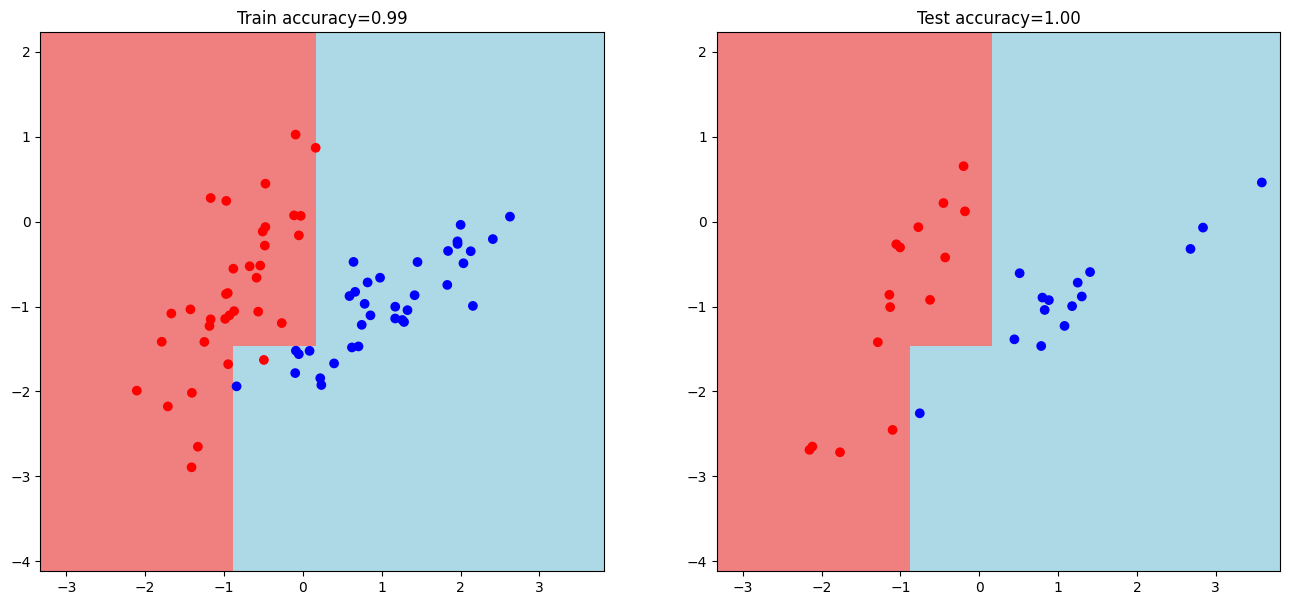

In [28]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# Define colors and light_colors for plotting
colors = plt.cm.get_cmap('RdBu', 2)
light_colors = plt.cm.get_cmap('RdBu', 2)

# Calculate accuracies
train_accuracy = my_tree.score(train_data, train_labels)
test_accuracy = my_tree.score(test_data, test_labels)

plt.figure(figsize = (16, 7))

# график обучающей выборки
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(my_tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()